In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load data from JSON file
file_path = 'C:/Users/HP/Desktop/output_pose_data_101801.json'  # Replace with your file path

data = []
with open(file_path) as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
# Convert JSON data to DataFrame
df = pd.DataFrame(data)

In [4]:
# Separate features and labels
X = df.drop('Label', axis=1).values
y = df['Label'].values

In [5]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [7]:
# Shape of each dataset
print("Number of samples in:")
print(f"Training data (X_train): {X_train.shape[0]}")
print(f"Testing data (X_test): {X_test.shape[0]}")

Number of samples in:
Training data (X_train): 750
Testing data (X_test): 188


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [9]:
# Reshape data for LSTM: (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [10]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [11]:
# Compile model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train model
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3053 - loss: 1.5804 - val_accuracy: 0.4415 - val_loss: 1.4286
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5091 - loss: 1.3521 - val_accuracy: 0.7181 - val_loss: 1.3050
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6475 - loss: 1.2646 - val_accuracy: 0.7234 - val_loss: 1.2323
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6466 - loss: 1.2260 - val_accuracy: 0.7340 - val_loss: 1.1789
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7258 - loss: 1.1449 - val_accuracy: 0.7340 - val_loss: 1.1233
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7212 - loss: 1.0995 - val_accuracy: 0.7500 - val_loss: 1.0705
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7144 - loss: 1.0601 - val_accuracy: 0.7660 - val_loss: 1.0265
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7733 - loss: 1.0038 - val_accuracy: 0.7713 - val_loss

In [13]:
# Save the history
with open('training_history.json', 'w') as f:
    json.dump(lstm_history.history, f)

In [14]:
# Save LSTM model
lstm_model.save('verification_lstm_model_json.h5')

In [15]:
from tensorflow.keras.models import load_model

# Load LSTM model
lstm_model = load_model('verification_lstm_model_json.h5')

In [17]:
import cv2
import mediapipe as mp
import math
import numpy as np

# Function to extract angles from the image
def extract_angles_from_image(image_path):
    # Initialize Mediapipe Pose model
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()

    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose estimation
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        # Extract keypoints
        landmarks = results.pose_landmarks.landmark

        # Get coordinates
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
        left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
        right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
        left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
        right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
        left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
        right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
        left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
        right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

        # Calculate angles
        left_elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
        right_elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
        left_shoulder_angle = calculate_angle(left_elbow, left_shoulder, left_hip)
        right_shoulder_angle = calculate_angle(right_elbow, right_shoulder, right_hip)
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)

        return {
            'left_elbow_angle': left_elbow_angle,
            'right_elbow_angle': right_elbow_angle,
            'left_shoulder_angle': left_shoulder_angle,
            'right_shoulder_angle': right_shoulder_angle,
            'left_knee_angle': left_knee_angle,
            'right_knee_angle': right_knee_angle
        }
    else:
        return None

# Function to calculate angle between three points
def calculate_angle(a, b, c):
    angle = math.degrees(math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    angle = abs(angle)
    if angle > 180.0:
        angle = 360 - angle
    return angle

# Function to predict the correctness of the pose
def predict_pose_correctness(image_path, model):
    angles = extract_angles_from_image(image_path)
    if angles is None:
        print("No pose landmarks detected.")
        return None

    angles_array = np.array(list(angles.values())).reshape(1, 1, 6)  # Reshape to (1, 1, 6) for LSTM input

    # Predict with the model
    prediction = model.predict(angles_array)
    correctness = prediction[0][0] > 0.5  # Binary classification threshold

    return "yes" if correctness else "no"


# Example usage:
if __name__ == "__main__":
    # Assuming you have already loaded or trained your model
    loaded_model = load_model('verification_lstm_model_json.h5')  # Load your trained LSTM model here

    # Example image path
    image_path = 'C:/Users/HP/Desktop/test_1.jpg'

    # Predict correctness
    result = predict_pose_correctness(image_path, loaded_model)

    if result is not None:
        print(f"The pose in '{image_path}' is predicted to be {result}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
The pose in 'C:/Users/HP/Desktop/test_1.jpg' is predicted to be yes.


In [18]:
import matplotlib.pyplot as plt
import json

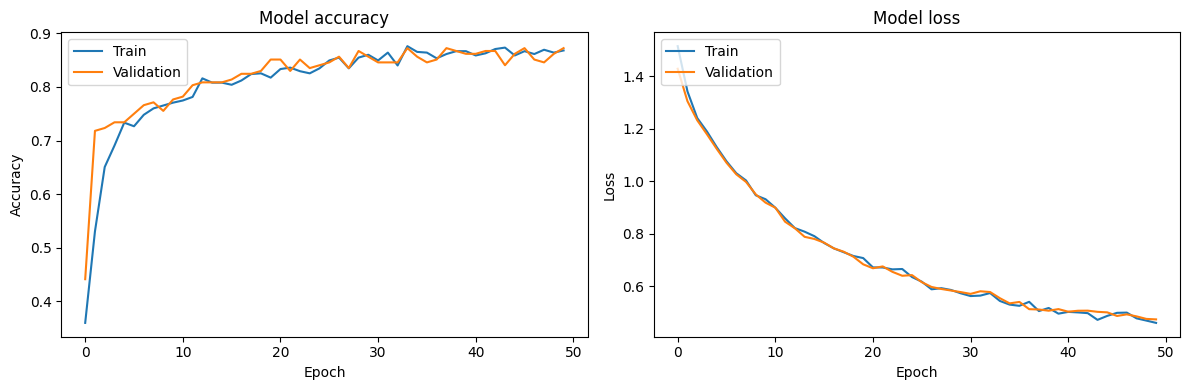

In [19]:
# Load the training history
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [21]:
# Load the saved model
model = tf.keras.models.load_model('verification_lstm_model_json.h5')

In [22]:
# Load data from JSON file
file_path = 'C:/Users/HP/Desktop/output_pose_data_101801.json'  # Replace with your file path

data = []
with open(file_path) as f:
    for line in f:
        data.append(json.loads(line))

# Convert JSON data to DataFrame
df = pd.DataFrame(data)

In [23]:
# Separate features and labels
X = df.drop(['Label'], axis=1).values
y = df['Label'].values

# Encode labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split (assuming we are only interested in evaluating the saved model)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [24]:
# Reshape X_test to have the shape (batch_size, timesteps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [25]:
# Make predictions on the test set and get the class with the highest probability
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Classification report for more detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Confusion Matrix:
[[32  0  0  0  0]
 [ 2 39  4  0  1]
 [ 0  0 38  0  2]
 [ 2  0  2 30  5]
 [ 1  1  3  1 25]]
Classification Report:
                 precision    recall  f1-score   support

        Downdog       0.86      1.00      0.93        32
 output_goddess       0.97      0.85      0.91        46
   output_plank       0.81      0.95      0.87        40
    output_tree       0.97      0.77      0.86        39
output_warrior2       0.76      0.81      0.78        31

       accuracy                           0.87       188
      macro avg       0.87      0.87      0.87       188
   weighted avg       0.88      0.87      0.87       188



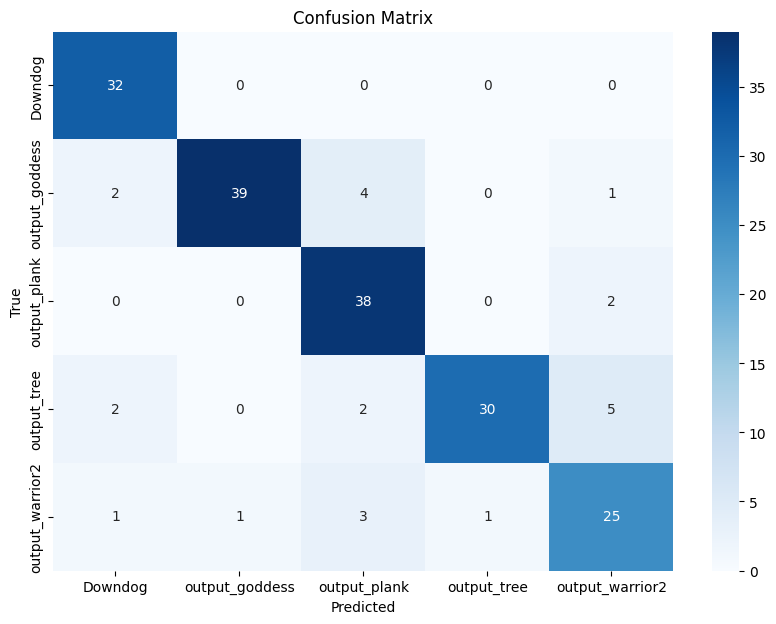

In [27]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()